### Importacion de librerias 

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns


### Extraer los datos

In [2]:
df = pd.read_csv("../data/clean_dataset.csv")
df

,condition,price,automatic_relist,initial_quantity,sold_quantity,available_quantity,free_shipping,local_pick_up,num_payment_methods,title_length,...,listing_gold,listing_gold_premium,listing_gold_pro,listing_gold_special,listing_silver,buying_auction,buying_buy_it_now,buying_classified,status_active,status_paused
0,1,80.0,0,1,0,1,0,1,3,60,...,0,0,0,0,0,0,1,0,1,0
1,0,2650.0,0,1,0,1,0,1,2,57,...,0,0,0,0,1,0,1,0,1,0
2,0,60.0,0,1,0,1,0,1,3,43,...,0,0,0,0,0,0,1,0,1,0
3,1,580.0,0,1,0,1,0,1,3,52,...,0,0,0,0,1,0,1,0,1,0
4,0,30.0,0,1,0,1,0,1,3,25,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97246,0,30.0,0,1,0,1,0,1,2,59,...,0,0,0,0,0,0,1,0,1,0
97247,1,239.0,0,5,0,5,0,0,2,60,...,0,0,0,0,0,0,1,0,1,0
97248,0,600.0,0,1,0,1,0,0,0,22,...,0,0,0,0,0,0,1,0,1,0
97249,0,50.0,0,1,0,1,0,1,2,47,...,0,0,0,0,0,0,1,0,1,0


### Entrenamiento del modelo

In [ ]:
X = df.drop(columns=['condition'])
y = df['condition']


num_cols = X.select_dtypes(include=['int64', 'float64']).columns


scaler = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')  

X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}


results = []

for name, estimator in models.items():
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    results.append({
        'Modelo': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1-Score': round(f1_score(y_test, y_pred), 4)
    })


results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\nResultados de los Modelos:")
print(results_df.to_string(index=False))



Resultados de los Modelos:
             Modelo  Accuracy  Precision  Recall  F1-Score
            XGBoost    0.8349     0.8513  0.8377    0.8445
  Gradient Boosting    0.8249     0.8381  0.8340    0.8360
      Random Forest    0.8101     0.8291  0.8125    0.8207
Logistic Regression    0.7388     0.6905  0.9277    0.7917


### Features más importantes del mejor modelo

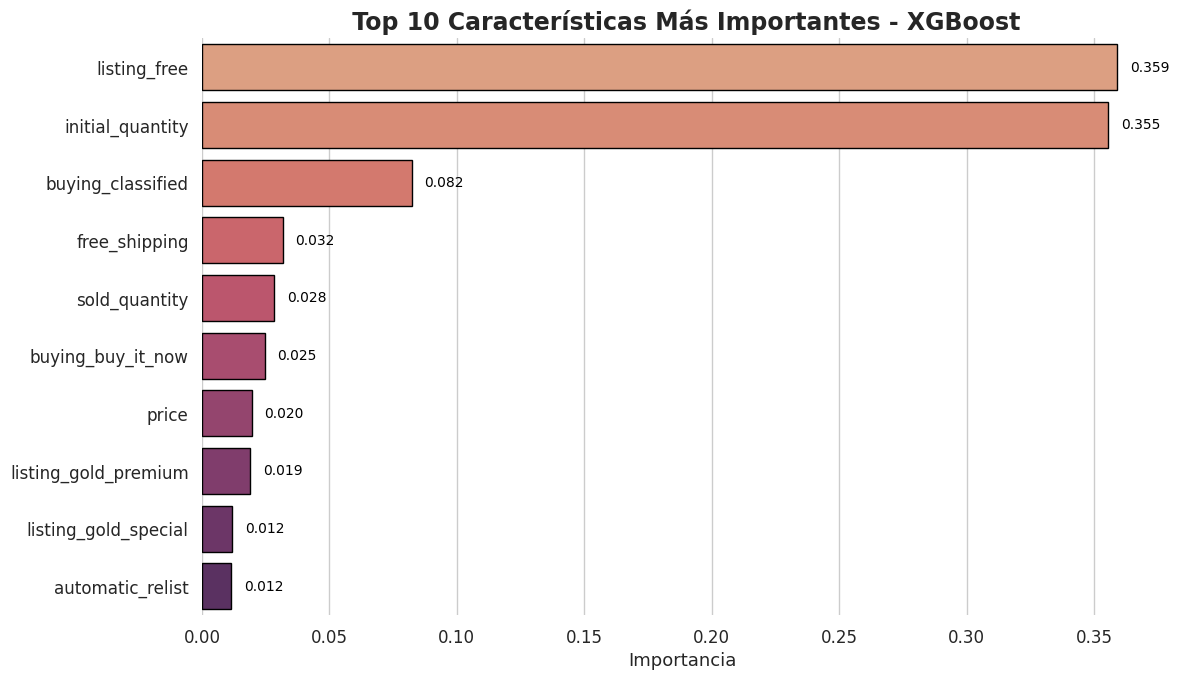

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_

feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X_scaled.shape[1])]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

sns.set(style='whitegrid', font='DejaVu Sans', font_scale=1.1)
plt.figure(figsize=(12, 7))

colors = sns.color_palette("flare", len(feature_importance_df))

barplot = sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    hue='Feature',        
    palette=colors,
    dodge=False,
    legend=False,
    edgecolor='black'
)

for i, (importance, feature) in enumerate(zip(feature_importance_df['Importance'], feature_importance_df['Feature'])):
    plt.text(importance + 0.005, i, f"{importance:.3f}", va='center', fontsize=10, color='black')

plt.title(' Top 10 Características Más Importantes - XGBoost', fontsize=17, weight='bold')
plt.xlabel('Importancia', fontsize=13)
plt.ylabel('')

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()
